In [2]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.metrics import mean_squared_error
import os
from matplotlib import pyplot as plt

PATH_TO_STOCKS = "./Datasets/Stocks/"
SELECTED = "Close"

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 

def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
        # extract raw values
        raw_values = series.values
        # transform data to be stationary
        diff_series = series.diff().dropna()
        diff_values = diff_series.values
        diff_values = diff_values.reshape(len(diff_values), 1)
        # rescale values to -1, 1
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_values = scaler.fit_transform(diff_values)
        scaled_values = scaled_values.reshape(len(scaled_values), 1)
        # transform into supervised learning problem X, y

        X, y = split_sequence(scaled_values, n_lag, n_seq)
        X_train, y_train = X[:-n_test], y[:-n_test]
        X_test, y_test = X[-n_test:], y[-n_test:]
        return scaler, X_train, y_train, X_test, y_test

In [3]:
# fit an LSTM network to training data
def create_model(X_train, y_train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
        # reshape training into [samples, timesteps, features]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        # design network
        model = Sequential()
        model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=False))
        # Adding the output layer
        model.add(Dense(units = y_train.shape[1]))
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.keras.metrics.MeanAbsoluteError()])
        
        return model

In [4]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

In [5]:
def make_forecasts(model, n_batch, X_test, n_lag, n_seq):
	forecasts = list()
	for i in range(X_test.shape[0]):
		# make forecast
		forecast = forecast_lstm(model, X_test[i], n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [59]:
def inverse_difference(last_ob, forecast):
        forecast_cumsum = forecast.cumsum()
        inverted = [last_ob]*len(forecast)
        inverted = [sum(x) for x in zip(inverted, forecast_cumsum)]
        return inverted

In [92]:
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
        inverted = list()
        for i in range(len(forecasts)):
            # create array from forecast
            forecast = np.array(forecasts[i])
            forecast = forecast.reshape(1, len(forecast))
            # invert scaling
            inv_scale = scaler.inverse_transform(forecast)
            inv_scale = inv_scale[0, :]
            
            # invert differencing
            index = len(series) - n_test + i - 1
            last_ob = series.values[index]
            inv_diff = inverse_difference(last_ob, inv_scale)
   
            inverted.append(inv_diff)
        return inverted

In [61]:
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = np.sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

In [114]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test, test_index):
    assert test_index<n_test and test_index>=0, \
        f'Please input a valid test_index. Must be larger than 0 and less than {n_test}'
    
    x_lim = int(len(series) * 0.95)
    y_lim_upper = np.max(forecasts) * 1.01
    y_lim_lower = min(np.min(series.iloc[x_lim:]), np.min(forecasts))*0.99
    
    # plot the entire dataset in blue
    plt.figure(figsize=(16,8))
    plt.plot(series.values, '-o', label='Actual')
    
    # plot the forecast
    start_index = len(series) - n_test + test_index - 1
    end_index = start_index + len(forecasts[test_index]) + 1
    xaxis = [x for x in range(start_index, end_index)]
    yaxis = [series.values[start_index]] + forecasts[test_index]
    plt.plot(xaxis, yaxis, '-o', color='orange', label='Predicted')
        
    # show the plot
    plt.axis([x_lim, len(series)+n_seq, y_lim_lower, y_lim_upper])
    plt.legend()
    plt.savefig("lstm_plot.png")
    plt.show()
    return

In [115]:
# load dataset
data = pd.read_csv(os.path.join(PATH_TO_STOCKS, "gty.us.txt"), delimiter = ",", parse_dates=['Date'], usecols=[0,1,2,3,4], index_col=['Date'])
series = data[SELECTED]

# configure
n_seq = 4
n_test = 30
n_lag = 8
n_epochs = 20
n_batch = 1
n_neurons = 50


In [116]:
# prepare data
scaler, X_train, y_train, X_test, y_test = prepare_data(series, n_test, n_lag, n_seq)

In [117]:
# fit model
model = create_model(X_train, y_train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

In [118]:
es = tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss')

In [75]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
for i in range(n_epochs):
    history = model.fit(X_train_reshaped, y_train, epochs=1, batch_size=n_batch, shuffle=False, callbacks=[es])
    #model.reset_states()

3159/3159 [==============================] - 5s 2ms/step - loss: 0.0048 - mean_absolute_error: 0.0442


In [119]:
# make forecasts
forecasts = make_forecasts(model, n_batch, X_test, n_lag, n_seq)
preds = forecasts

In [120]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+n_seq-1)

In [121]:
actual = [row.reshape(-1) for row in y_test]
actual = inverse_transform(series, actual, scaler, n_test+n_seq-1)

t+1 RMSE: 2.789805
t+2 RMSE: 7.657876
t+3 RMSE: 11.035449
t+4 RMSE: 14.117019


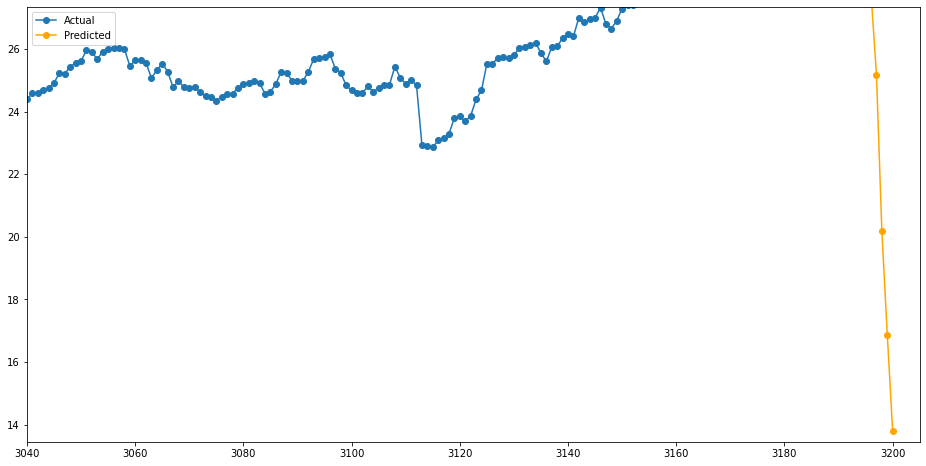

In [122]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

# plot forecasts
plot_forecasts(series, forecasts, n_test+n_seq-1, 29)